## 1. Import Libraries and Initialize Global Variables

Import necessary libraries and define global variables for dataframes and models.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from ipywidgets import interact, widgets
import warnings

# Configure environment
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Global variables
age_income_df = None
age_geo_df = None
charging_df = None
ev_sales_df = None
master_df = None
models = {}
feature_importance = None

## 2. Load and Engineer Features

Load datasets and engineer advanced features using global dataframes.

In [21]:
def load_and_engineer_features():
    """Advanced data loading with feature engineering"""
    global age_income_df, age_geo_df, charging_df, ev_sales_df
    
    # Load datasets
    try:
        age_income_df = pd.read_csv('age_income_df.csv')
        age_geo_df = pd.read_csv('age_geo.csv') 
        charging_df = pd.read_csv('charg.csv')
        ev_sales_df = pd.read_csv('df_ev_sales_final_cleaned.csv')
        print("All datasets loaded")
    except Exception as e:
        print(f"Error:{e}")
        return False
            
    # Clean state names
    def clean_state(state):
        if pd.isna(state): return state
        return str(state).split('(')[0].strip().upper()
    
    for df in [age_income_df, age_geo_df, charging_df]:
        df['state_clean'] = df['state'].apply(clean_state)
    
    # ADVANCED FEATURE ENGINEERING
    
    # 1. Age-Income Interaction Features
    age_income_df['youth_dominance'] = (
        age_income_df['age_0_29_percent'] - age_income_df['age_50_plus_percent']
    )
    age_income_df['working_age_focus'] = (
        age_income_df['age_30_49_percent'] * 1.2 + age_income_df['age_0_29_percent'] * 0.8
    )
    
    # 2. Economic Power Features
    income_mapping = {'50-100k': 75, '100-200k': 150, '200k+': 300}
    age_income_df['income_numeric'] = age_income_df['monthly_income_bracket'].map(income_mapping)
    age_income_df['economic_power'] = (
        age_income_df['income_numeric'] * age_income_df['asset_ownership_score'] 
        * age_income_df['literacy_rate'] / 10000
    )
    
    # 3. Infrastructure Efficiency Features
    charging_df['infrastructure_efficiency'] = (
        charging_df['operational_chargers'] / (charging_df['sanctioned_chargers'] + 1)
    )
    charging_df['demand_supply_ratio'] = (
        charging_df['total_evs'] / (charging_df['operational_chargers'] + 1)
    )
    
    # 4. Market Maturity Features
    age_geo_df['market_potential'] = (
        age_geo_df['market_maturity_score'] * age_geo_df['urbanization_rate'] / 100
    )
    
    # 5. EV Sales Growth Features
    sales_cols = [col for col in ev_sales_df.columns if 'Sales_' in col]
    if len(sales_cols) >= 4:
        # Recent momentum (2022-2024 vs 2019-2021)
        recent_cols = [col for col in sales_cols if '2022' in col or '2023' in col or '2024' in col]
        older_cols = [col for col in sales_cols if '2019' in col or '2020' in col or '2021' in col]
        
        for col in recent_cols + older_cols:
            ev_sales_df[col] = pd.to_numeric(ev_sales_df[col], errors='coerce').fillna(0)
        
        ev_sales_df['recent_sales'] = ev_sales_df[recent_cols].sum(axis=1)
        ev_sales_df['older_sales'] = ev_sales_df[older_cols].sum(axis=1)
        ev_sales_df['growth_momentum'] = (
            (ev_sales_df['recent_sales'] - ev_sales_df['older_sales']) / 
            (ev_sales_df['older_sales'] + 1)
        )
    
    return True

## 3. Create Master Dataset

Merge datasets into a comprehensive master dataframe.

In [22]:
def create_master_dataset():
    """Create comprehensive master dataset"""
    global master_df, age_income_df, age_geo_df, charging_df, ev_sales_df
    
    # Start with age_income as base
    master = age_income_df.copy()
    
    # Aggregate geographic data by state
    geo_agg = age_geo_df.groupby('state_clean').agg({
        'market_maturity_score': 'mean',
        'urbanization_rate': 'mean', 
        'ev_manufacturers_count': 'sum',
        'market_potential': 'mean'
    }).reset_index()
    
    # Merge datasets
    master = master.merge(geo_agg, on='state_clean', how='left')
    master = master.merge(charging_df[['state_clean', 'operational_chargers', 'total_evs', 
                                           'infrastructure_efficiency', 'demand_supply_ratio']], 
                         on='state_clean', how='left')
    
    # Sales data aggregation by category
    sales_by_category = ev_sales_df.groupby('Category').agg({
        'growth_momentum': 'mean',
        'recent_sales': 'sum',
        'Total_EV_Sales': 'sum'
    }).reset_index()
    
    # Add category insights as features
    dominant_category = sales_by_category.loc[sales_by_category['Total_EV_Sales'].idxmax()]
    master['dominant_category_growth'] = dominant_category['growth_momentum']
    master['category_market_size'] = dominant_category['Total_EV_Sales']
    
    # Handle missing values intelligently
    numeric_cols = master.select_dtypes(include=[np.number]).columns
    master[numeric_cols] = master[numeric_cols].fillna(master[numeric_cols].median())
    
    # Create composite growth potential score
    master['growth_potential_score'] = (
        master['ev_adoption_propensity'] * 0.3 +
        master['economic_power'] * 0.25 +
        master['market_potential'] * 0.2 +
        master['infrastructure_efficiency'] * 0.15 +
        master['dominant_category_growth'] * 0.1
    )
    
    master_df = master
    print(f"Master dataset created: {master.shape[0]} records, {master.shape[1]} features")
    
    return master

## 4. Advanced Statistical Analysis

Perform statistical analysis with significance testing and visualizations.

In [23]:
def advanced_statistical_analysis():
    """statistical analysis"""
    global master_df

    
    # Feature correlation matrix with statistical significance
    numeric_features = master_df.select_dtypes(include=[np.number]).columns
    correlation_matrix = master_df[numeric_features].corr()
    
    # Statistical significance testing
    def correlation_significance(df, target='ev_adoption_propensity'):
        import scipy.stats as stats_local
        results = {}
        for col in numeric_features:
            if col != target and col in df.columns:
                try:
                    # Remove NaN values for both variables
                    x = df[col].dropna()
                    y = df[target].dropna()
                    
                    # Find common indices
                    common_idx = x.index.intersection(y.index)
                    if len(common_idx) > 2:  # Need at least 3 points for correlation
                        corr, p_value = stats_local.pearsonr(x[common_idx], y[common_idx])
                        results[col] = {'correlation': corr, 'p_value': p_value, 'significant': p_value < 0.05}
                except Exception as e:
                    print(f"   Warning: Could not calculate correlation for {col}: {e}")
                    continue
        return results
    
    significance_results = correlation_significance(master_df)
    
    # Display significant correlations
    print("SIGNIFICANT CORRELATIONS (p < 0.05):")
    significant_features = []
    for feature, stats in significance_results.items():
        if stats['significant']:
            significant_features.append(feature)
            print(f"   {feature}: r={stats['correlation']:.3f}, p={stats['p_value']:.4f}")
    
    # Visualization - make it more robust
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Correlation heatmap - use only available features
    available_features = ['ev_adoption_propensity']
    optional_features = ['economic_power', 'market_potential', 'infrastructure_efficiency', 
                       'growth_potential_score', 'youth_dominance']
    
    for feat in optional_features:
        if feat in master_df.columns:
            available_features.append(feat)
    
    if len(available_features) > 1:
        sns.heatmap(master_df[available_features].corr(), annot=True, cmap='RdYlBu_r', ax=ax1)
        ax1.set_title('Feature Correlation Matrix')
    else:
        ax1.text(0.5, 0.5, 'Insufficient features for correlation matrix', 
                ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Correlation Matrix - Data Issue')
    
    # Growth potential distribution
    if 'growth_potential_score' in master_df.columns:
        sns.histplot(master_df['growth_potential_score'], bins=30, ax=ax2)
        ax2.set_title('Growth Potential Score Distribution')
    else:
        ax2.text(0.5, 0.5, 'Growth potential score not available', 
                ha='center', va='center', transform=ax2.transAxes)
    
    # Economic power vs EV adoption
    if 'economic_power' in master_df.columns:
        sns.scatterplot(data=master_df, x='economic_power', y='ev_adoption_propensity', 
                       hue='monthly_income_bracket', ax=ax3)
        ax3.set_title('Economic Power vs EV Adoption')
    else:
        sns.scatterplot(data=master_df, x='asset_ownership_score', y='ev_adoption_propensity', 
                       hue='monthly_income_bracket', ax=ax3)
        ax3.set_title('Asset Ownership vs EV Adoption')
    
    # State-wise growth potential (top 10)
    if 'growth_potential_score' in master_df.columns:
        top_growth_states = master_df.nlargest(10, 'growth_potential_score')
        sns.barplot(data=top_growth_states, y='state_clean', x='growth_potential_score', ax=ax4)
        ax4.set_title('Top 10 States by Growth Potential')
    else:
        top_adoption_states = master_df.nlargest(10, 'ev_adoption_propensity')
        sns.barplot(data=top_adoption_states, y='state_clean', x='ev_adoption_propensity', ax=ax4)
        ax4.set_title('Top 10 States by EV Adoption')
    
    plt.tight_layout()
    plt.show()
    
    return significant_features

## 5. ML-Powered Market Segmentation

Use K-Means clustering to identify market segments.

In [24]:
def ml_powered_segmentation():
    """clustering for market segments"""
    global master_df
    
    # Prepare features for clustering - use available features
    base_features = ['ev_adoption_propensity', 'asset_ownership_score', 'literacy_rate']
    optional_features = ['economic_power', 'market_potential', 'infrastructure_efficiency', 
                       'youth_dominance', 'growth_potential_score']
    
    feature_cols = base_features.copy()
    for feat in optional_features:
        if feat in master_df.columns:
            feature_cols.append(feat)
    
    print(f"Using features for clustering: {feature_cols}")
    
    X = master_df[feature_cols].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # K-Means clustering with optimal K
    inertias = []
    K_range = range(2, min(8, len(master_df)//2))  # Ensure we don't have more clusters than reasonable
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
    
    # Choose optimal K (simple heuristic - can be improved)
    optimal_k = min(4, len(K_range))
    
    # Final clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    master_df['growth_segment'] = kmeans.fit_predict(X_scaled)
    
    # Segment analysis
    segment_analysis = master_df.groupby('growth_segment').agg({
        'ev_adoption_propensity': ['mean', 'std', 'count'],
        'asset_ownership_score': 'mean',
        'total_population': 'sum'
    }).round(3)
    
    print("GROWTH SEGMENTS:")
    print(segment_analysis)
    
    # Segment visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Segment scatter plot - use available features
    x_feature = 'asset_ownership_score' if 'economic_power' not in master_df.columns else 'economic_power'
    
    sns.scatterplot(data=master_df, x=x_feature, y='ev_adoption_propensity',
                   hue='growth_segment', size='total_population', ax=ax1)
    ax1.set_title('Market Segments by Growth Potential')
    
    # Segment characteristics heatmap
    segment_means = master_df.groupby('growth_segment')[feature_cols].mean()
    sns.heatmap(segment_means.T, annot=True, cmap='YlOrRd', ax=ax2)
    ax2.set_title('Segment Characteristics Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    # Identify high-growth segment - use available metric
    growth_metric = 'growth_potential_score' if 'growth_potential_score' in segment_analysis.columns else ('ev_adoption_propensity', 'mean')
    
    if isinstance(growth_metric, tuple):
        high_growth_segment = segment_analysis[growth_metric[0]][growth_metric[1]].idxmax()
    else:
        high_growth_segment = segment_analysis[growth_metric]['mean'].idxmax()
        
    print(f"\nHIGH GROWTH SEGMENTS: Segment {high_growth_segment}")
    
    return high_growth_segment

## 6. Predictive Modeling

Build ML models to predict EV adoption propensity.

In [29]:
def predictive_modeling():
    """predict growth potential"""
    global master_df, models, feature_importance

    
    # Prepare data for modeling
    feature_cols = ['economic_power', 'market_potential', 'infrastructure_efficiency', 
                   'youth_dominance', 'age_30_49_percent', 'income_numeric', 
                   'literacy_rate', 'urbanization_rate']
    
    X = master_df[feature_cols].fillna(0)
    y = master_df['ev_adoption_propensity']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Multiple models for ensemble validation
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        
        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Metrics
        results[name] = {
            'cv_score_mean': cv_scores.mean(),
            'cv_score_std': cv_scores.std(),
            'test_r2': r2_score(y_test, y_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred))
        }
    
    print("MODEL PERFORMANCE:")
    for name, metrics in results.items():
        print(f"   {name}:")
        print(f"     CV R²: {metrics['cv_score_mean']:.3f} (±{metrics['cv_score_std']:.3f})")
        print(f"     Test R²: {metrics['test_r2']:.3f}")
        print(f"     RMSE: {metrics['test_rmse']:.4f}")
    
    # Feature importance from best model
    best_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTOP GROWTH DRIVERS:")
    print(feature_importance.head(5))
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Feature importance
    sns.barplot(data=feature_importance.head(8), x='importance', y='feature', ax=ax1)
    ax1.set_title('Feature Importance for EV Adoption Prediction')
    
    # Actual vs Predicted
    y_pred_full = best_model.predict(X)
    sns.scatterplot(x=y, y=y_pred_full, ax=ax2)
    ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax2.set_xlabel('Actual EV Adoption')
    ax2.set_ylabel('Predicted EV Adoption')
    ax2.set_title(f'Prediction Accuracy (R² = {r2_score(y, y_pred_full):.3f})')
    
    plt.tight_layout()
    plt.show()
    
    return results

## 7. Growth Opportunity Ranking

Rank growth opportunities across income brackets and states.

In [30]:
def growth_opportunity_ranking():
    """Final growth opportunity ranking"""
    global master_df, models, ev_sales_df

    
    # Create comprehensive growth score using ML predictions
    if 'Random Forest' in models:
        best_model = models['Random Forest']
        feature_cols = ['economic_power', 'market_potential', 'infrastructure_efficiency', 
                       'youth_dominance', 'age_30_49_percent', 'income_numeric', 
                       'literacy_rate', 'urbanization_rate']
        
        # Use only available features
        available_features = [col for col in feature_cols if col in master_df.columns]
        if not available_features:
            # Fallback to basic features
            available_features = ['asset_ownership_score', 'literacy_rate', 'age_30_49_percent']
            available_features = [col for col in available_features if col in master_df.columns]
        
        print(f"Using features for prediction: {available_features}")
        
        if available_features:
            X = master_df[available_features].fillna(0)
            predicted_adoption = best_model.predict(X)
            master_df['ml_predicted_adoption'] = predicted_adoption
        else:
            master_df['ml_predicted_adoption'] = master_df['ev_adoption_propensity']
    else:
        master_df['ml_predicted_adoption'] = master_df['ev_adoption_propensity']
    
    # Create growth momentum with available features
    growth_components = []
    weights = []
    
    if 'ml_predicted_adoption' in master_df.columns:
        growth_components.append(master_df['ml_predicted_adoption'])
        weights.append(0.4)
    
    if 'growth_potential_score' in master_df.columns:
        growth_components.append(master_df['growth_potential_score'])
        weights.append(0.3)
    else:
        growth_components.append(master_df['ev_adoption_propensity'])
        weights.append(0.3)
        
    if 'economic_power' in master_df.columns:
        growth_components.append(master_df['economic_power'])
        weights.append(0.2)
    else:
        growth_components.append(master_df['asset_ownership_score'])
        weights.append(0.2)
        
    if 'market_potential' in master_df.columns:
        growth_components.append(master_df['market_potential'])
        weights.append(0.1)
    else:
        growth_components.append(master_df['literacy_rate'] / 100)
        weights.append(0.1)
    
    # Normalize weights
    weights = np.array(weights)
    weights = weights / weights.sum()
    
    # Calculate growth momentum
    master_df['growth_momentum'] = sum(w * comp for w, comp in zip(weights, growth_components))
    
    # Growth opportunity analysis
    growth_ranking = master_df.groupby(['monthly_income_bracket', 'state_clean']).agg({
        'growth_momentum': 'mean',
        'ml_predicted_adoption': 'mean',
        'total_population': 'sum',
        'age_30_49_percent': 'mean',
    }).sort_values('growth_momentum', ascending=False).head(15)
    
    # Add economic power if available
    if 'economic_power' in master_df.columns:
        growth_ranking['economic_power'] = master_df.groupby(['monthly_income_bracket', 'state_clean'])['economic_power'].mean()
    else:
        growth_ranking['economic_power'] = master_df.groupby(['monthly_income_bracket', 'state_clean'])['asset_ownership_score'].mean()
    
    print("TOP 15:")
    print("   (Income Bracket, State) -> Growth Score, Population, Economic Power")
    for idx, row in growth_ranking.iterrows():
        bracket, state = idx
        econ_power = row['economic_power'] if 'economic_power' in row else row.get('asset_ownership_score', 0)
        print(f"   {bracket:10} | {state:15} -> {row['growth_momentum']:.3f} | "
              f"Pop: {row['total_population']:8,.0f} | EconPower: {econ_power:.2f}")
    
    # Age group analysis with ML validation
    if 'age_30_49_percent' in master_df.columns:
        # Create age group categories based on actual column values
        age_30_49_high = master_df['age_30_49_percent'] > 30
        age_growth = master_df.groupby(age_30_49_high).agg({
            'growth_momentum': 'mean',
            'ml_predicted_adoption': 'mean',
        })
        
        if 'economic_power' in master_df.columns:
            age_growth['economic_power'] = master_df.groupby(age_30_49_high)['economic_power'].mean()
        
        print(f"\nAGE GROUP GROWTH ANALYSIS:")
        if True in age_growth.index:
            print(f"   High 30-49% areas (>30%): Growth={age_growth.loc[True, 'growth_momentum']:.3f}")
        if False in age_growth.index:
            print(f"   Lower 30-49% areas (≤30%): Growth={age_growth.loc[False, 'growth_momentum']:.3f}")
    else:
        print(f"\n📊 AGE GROUP ANALYSIS: age_30_49_percent column not found")
    
    # Vehicle type recommendation based on growth analysis
    if 'growth_momentum' in ev_sales_df.columns:
        vehicle_growth = ev_sales_df.groupby('Category').agg({
            'growth_momentum': 'mean',
            'recent_sales': 'sum',
            'Total_EV_Sales': 'sum'
        }).sort_values('growth_momentum', ascending=False)
        
        print(f"\nVEHICLE TYPE GROWTH RANKING:")
        print(vehicle_growth)
    else:
        # Fallback analysis
        vehicle_growth = ev_sales_df.groupby('Category').agg({
            'Total_EV_Sales': 'sum'
        }).sort_values('Total_EV_Sales', ascending=False)
        print(f"\nVEHICLE TYPE BY TOTAL SALES:")
        print(vehicle_growth.head())
    
    return growth_ranking

## 8. Generate ML Insights

Consolidate analysis results into actionable business insights.

In [31]:
def generate_ml_insights():
    """Generate final ML-driven business insights"""
    global master_df, feature_importance, ev_sales_df
    
    # Top insights based on ML analysis
    if feature_importance is not None:
        top_features = feature_importance.head(3)['feature'].tolist()
        
        print("KEY GROWTH DRIVERS:")
        for i, feature in enumerate(top_features, 1):
            importance = feature_importance[feature_importance['feature'] == feature]['importance'].iloc[0]
            print(f"   {i}. {feature.replace('_', ' ').title()}: {importance:.3f} importance")
    else:
        print("KEY GROWTH DRIVERS: Feature importance not available")
    
    # Optimal segments
    if 'growth_momentum' in master_df.columns:
        high_growth_areas = master_df[
            master_df['growth_momentum'] > master_df['growth_momentum'].quantile(0.8)
        ]
        
        if not high_growth_areas.empty:
            optimal_age = high_growth_areas['age_30_49_percent'].mean()
            optimal_income = high_growth_areas['monthly_income_bracket'].mode()
            optimal_income_value = optimal_income.iloc[0] if not optimal_income.empty else "100-200k"
            optimal_states = high_growth_areas['state_clean'].value_counts().head(3)
            
            print(f"\nOPTIMAL TARGETING STRATEGY:")
            print(f"   Target Age Focus: {optimal_age:.1f}% in 30-49 age group")
            print(f"   Optimal Income Bracket: {optimal_income_value}")
            print(f"   Top Growth States: {list(optimal_states.index[:3])}")
        else:
            print(f"\nOPTIMAL TARGETING STRATEGY:")
            print("   Analysis shows insufficient high-growth segments")
    
    # Vehicle type recommendation
    if 'growth_momentum' in ev_sales_df.columns:
        best_vehicle_idx = ev_sales_df['growth_momentum'].idxmax()
        best_vehicle_category = ev_sales_df.loc[best_vehicle_idx, 'Category']
    else:
        # Fallback to total sales
        best_vehicle_idx = ev_sales_df['Total_EV_Sales'].idxmax()
        best_vehicle_category = ev_sales_df.loc[best_vehicle_idx, 'Category']
    
    print(f"   Recommended Vehicle Type: {best_vehicle_category}")
    
    # Investment priority matrix
    if 'growth_momentum' in master_df.columns:
        investment_priority = master_df.groupby('state_clean').agg({
            'growth_momentum': 'mean',
            'total_population': 'sum',
        }).sort_values(['growth_momentum', 'total_population'], ascending=False)
        
        if 'economic_power' in master_df.columns:
            investment_priority['economic_power'] = master_df.groupby('state_clean')['economic_power'].mean()
        
        print(f"\nINVESTMENT PRIORITY RANKING (Top 5):")
        for i, (state, data) in enumerate(investment_priority.head(5).iterrows(), 1):
            print(f"   {i}. {state}: Growth={data['growth_momentum']:.3f}, "
                  f"Market Size={data['total_population']:,.0f}")
    


## 9. Run Complete Analysis

Execute the full analysis pipeline.

All datasets loaded
Master dataset created: 1204 records, 28 features
SIGNIFICANT CORRELATIONS (p < 0.05):
   total_population: r=0.111, p=0.0001
   age_0_29_percent: r=-0.772, p=0.0000
   age_30_49_percent: r=0.810, p=0.0000
   age_50_plus_percent: r=0.628, p=0.0000
   literacy_rate: r=0.924, p=0.0000
   avg_household_size: r=-0.503, p=0.0000
   asset_ownership_score: r=0.875, p=0.0000
   youth_dominance: r=-0.730, p=0.0000
   working_age_focus: r=-0.350, p=0.0000
   income_numeric: r=0.464, p=0.0000
   economic_power: r=0.666, p=0.0000
   market_maturity_score: r=0.687, p=0.0000
   urbanization_rate: r=0.599, p=0.0000
   ev_manufacturers_count: r=0.333, p=0.0000
   market_potential: r=0.573, p=0.0000
   operational_chargers: r=0.193, p=0.0000
   infrastructure_efficiency: r=0.094, p=0.0011
   demand_supply_ratio: r=-0.177, p=0.0000
   growth_potential_score: r=0.679, p=0.0000


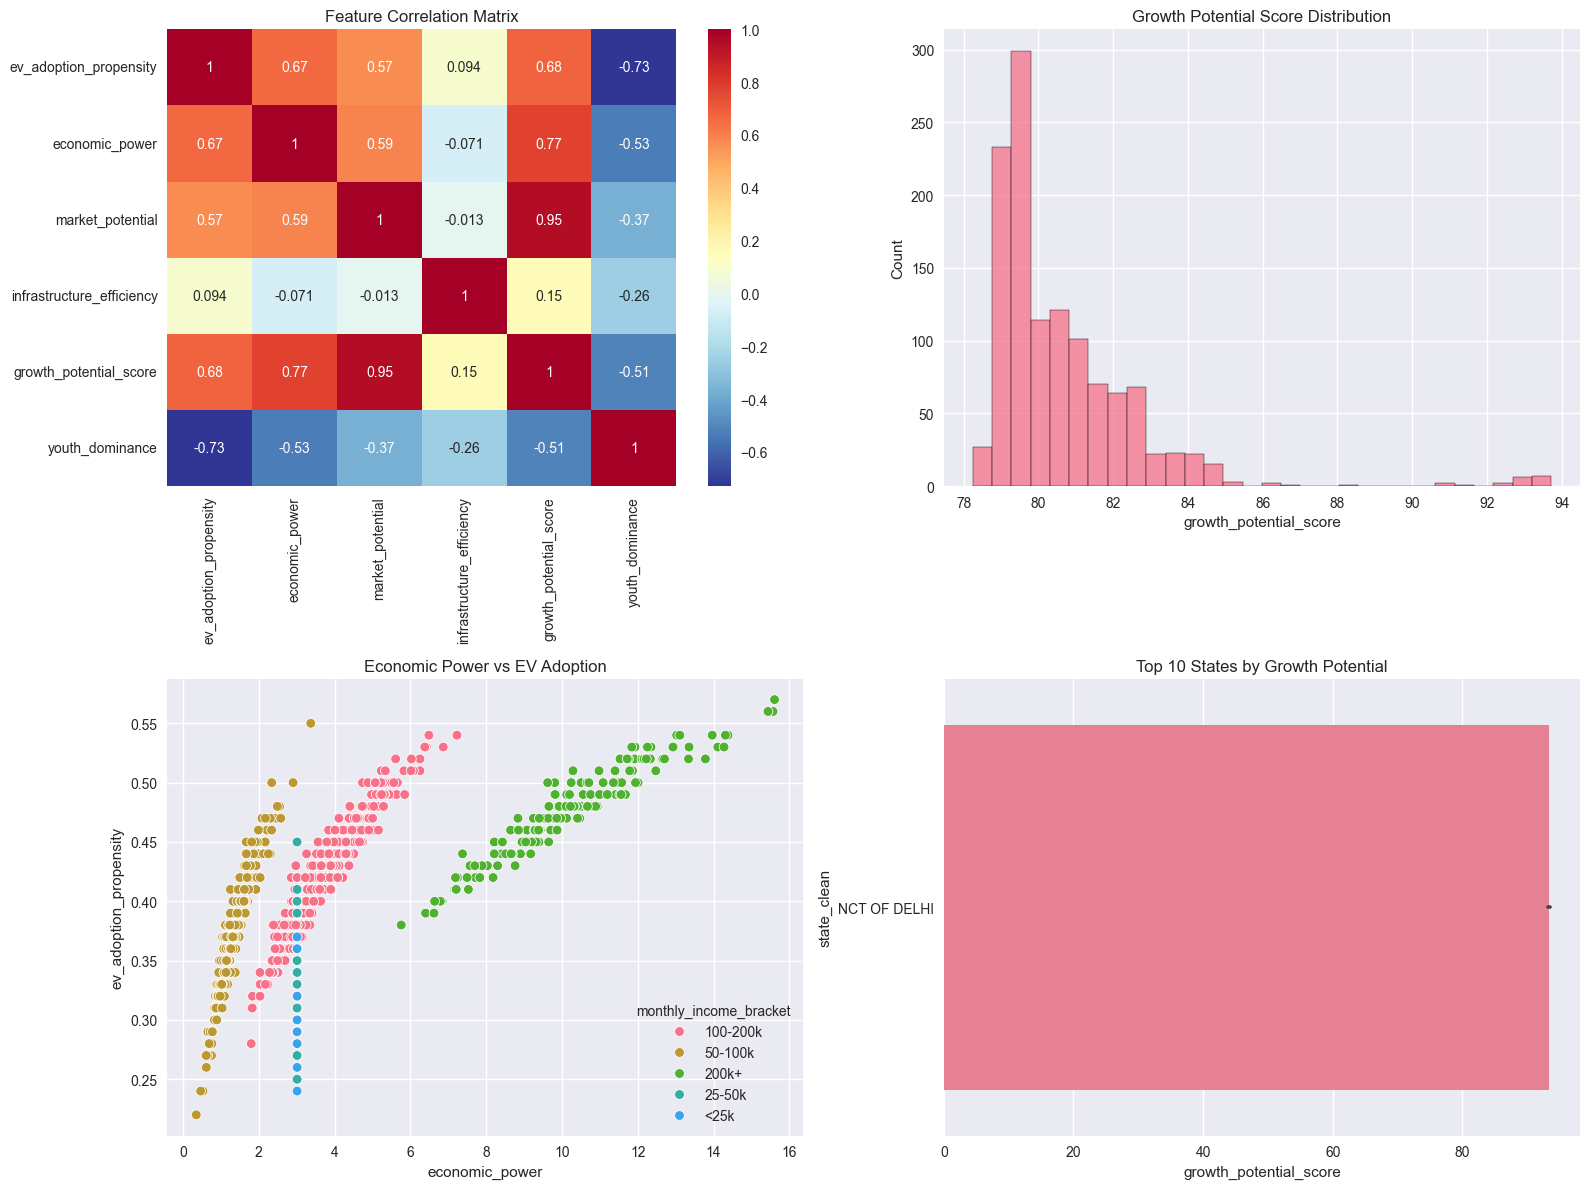

Using features for clustering: ['ev_adoption_propensity', 'asset_ownership_score', 'literacy_rate', 'economic_power', 'market_potential', 'infrastructure_efficiency', 'youth_dominance', 'growth_potential_score']
GROWTH SEGMENTS:
               ev_adoption_propensity              asset_ownership_score  \
                                 mean    std count                  mean   
growth_segment                                                             
0                               0.423  0.030   415                 3.269   
1                               0.479  0.031   190                 4.325   
2                               0.336  0.036   580                 2.354   
3                               0.529  0.018    19                 5.178   

               total_population  
                            sum  
growth_segment                   
0                     829249440  
1                     446470823  
2                    1055032473  
3                      35026931  


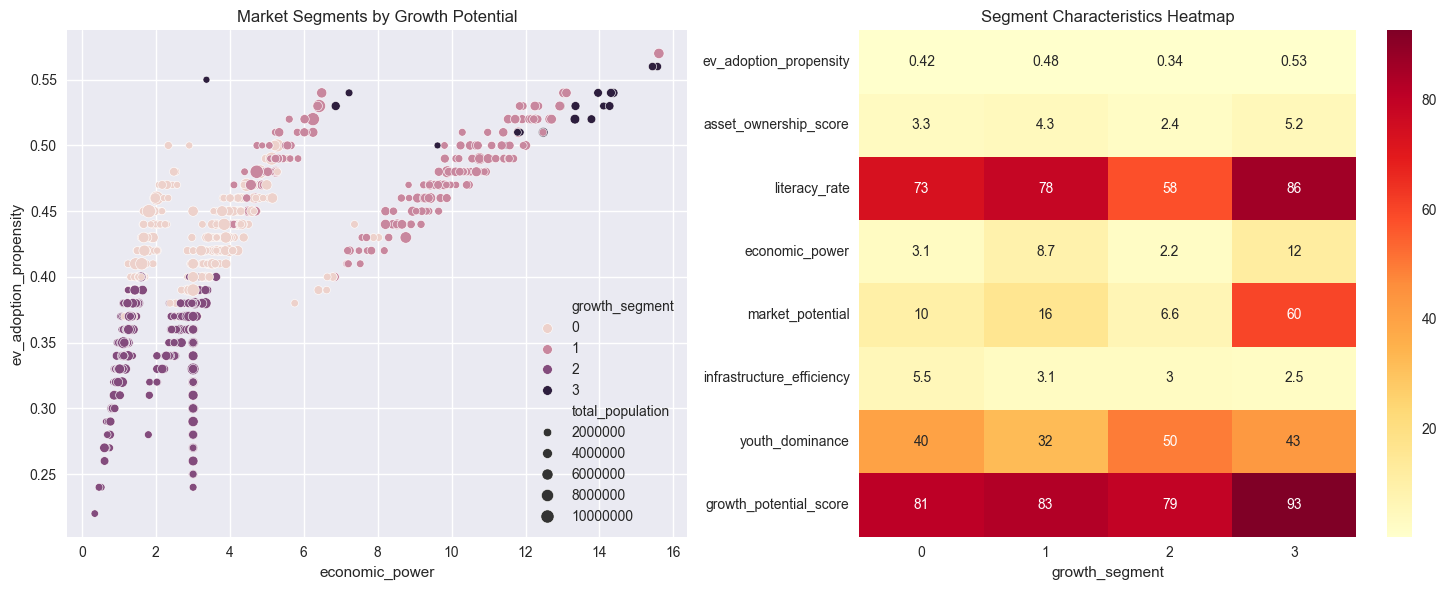


HIGH GROWTH SEGMENTS: Segment 3
MODEL PERFORMANCE:
   Random Forest:
     CV R²: 0.974 (±0.003)
     Test R²: 0.976
     RMSE: 0.0105
   Gradient Boosting:
     CV R²: 0.978 (±0.002)
     Test R²: 0.980
     RMSE: 0.0095

TOP GROWTH DRIVERS:
             feature  importance
6      literacy_rate    0.775175
0     economic_power    0.182977
4  age_30_49_percent    0.023222
3    youth_dominance    0.010248
7  urbanization_rate    0.002754


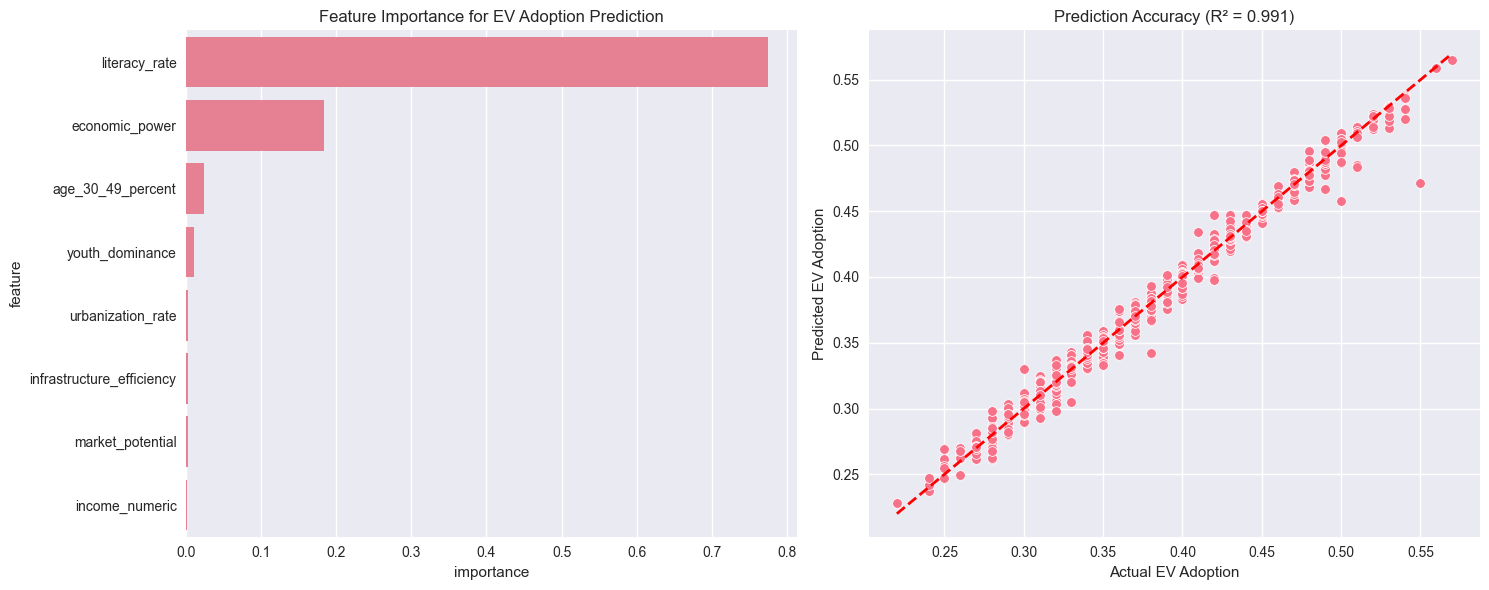

Using features for prediction: ['economic_power', 'market_potential', 'infrastructure_efficiency', 'youth_dominance', 'age_30_49_percent', 'income_numeric', 'literacy_rate', 'urbanization_rate']
TOP 15:
   (Income Bracket, State) -> Growth Score, Population, Economic Power
   200k+      | NCT OF DELHI    -> 37.003 | Pop: 29,977,625 | EconPower: 13.50
   200k+      | CHANDIGARH      -> 36.815 | Pop: 1,055,450 | EconPower: 14.11
   100-200k   | NCT OF DELHI    -> 35.175 | Pop: 2,731,929 | EconPower: 6.87
   100-200k   | CHANDIGARH      -> 34.919 | Pop: 1,055,450 | EconPower: 7.23
   50-100k    | NCT OF DELHI    -> 34.196 | Pop:  142,004 | EconPower: 3.37
   200k+      | LAKSHADWEEP     -> 32.655 | Pop:   64,473 | EconPower: 9.62
   100-200k   | LAKSHADWEEP     -> 31.351 | Pop:   64,473 | EconPower: 4.88
   200k+      | GOA             -> 31.296 | Pop: 1,458,545 | EconPower: 9.80
   100-200k   | GOA             -> 30.044 | Pop: 1,458,545 | EconPower: 5.24
   200k+      | KERALA          -

In [32]:
def run_complete_analysis():    
    # Execute analysis pipeline
    if not load_and_engineer_features():
        return
    
    create_master_dataset()
    advanced_statistical_analysis()
    ml_powered_segmentation()
    predictive_modeling()
    growth_opportunity_ranking()
    generate_ml_insights()

# Run the analysis
run_complete_analysis()